# 1. Introduction

**Generative Adversarial Networks (GANs)** are a powerful framework for training generative models, meaning models that can generate new, realistic data samples. The basic idea behind GANs is to have **two neural networks**, a generator, and a discriminator, that are trained simultaneously through adversarial training.

Generative models aim to learn the underlying distribution of a dataset to generate new samples that resemble the training data.
GANs fall under the category of generative models, along with other approaches like Variational Autoencoders (VAEs).

**Generator Network:**

The generator is a neural network that takes random noise as input and generates synthetic data samples. The goal of the generator is to produce data that is indistinguishable from real data.

**Discriminator Network:**

The discriminator is another neural network that takes input data (either real or generated) and predicts whether it is real or fake. The goal of the discriminator is to correctly classify real and generated data.

**Adversarial Training:**

The generator and discriminator are trained simultaneously through a competitive process. The generator aims to improve its ability to generate realistic data to fool the discriminator. The discriminator aims to improve its ability to distinguish between real and generated data.

**Objective Function:**

The training process involves minimizing a specific objective function, often referred to as the adversarial loss or minimax loss.
The generator and discriminator are involved in a game where the generator tries to minimize the discriminator's ability to distinguish between real and fake data.
Training Steps:

During each training step, the generator generates fake data, and the discriminator classifies both real and fake data.
The gradients from the discriminator's predictions are backpropagated to update the weights of the discriminator.
Simultaneously, the gradients from the generator's output are backpropagated to update the weights of the generator.
This process is repeated iteratively until the generator produces realistic data.
Convergence:

Ideally, the generator and discriminator reach a point where the generator generates data that is indistinguishable from real data, and the discriminator cannot reliably classify between real and fake data.


Here, we will use **DCGAN (Deep Convolutional GAN)** to generate fake images.

# 2. Import Library & Data

In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, AvgPool2D, Reshape, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.metrics import BinaryCrossentropy  # Use TensorFlow's metrics module
import os
import PIL
import time
from IPython import display

In [ ]:
# Define the root path for the dataset
root_path = "animefacedataset/images"
root_path = pathlib.Path(root_path)

# 3. Prepare the Data & View some samples

In [ ]:
# Preparing data
batch_size = 32

# Use pathlib for compatibility and consistency
data_directory = pathlib.Path(root_path)

# Load images from the directory
data = keras.utils.image_dataset_from_directory(
    directory=data_directory,
    label_mode=None,  # No labels for GAN training
    batch_size=batch_size,
    image_size=(64, 64)
)

Found 63565 files belonging to 1 classes.


In [ ]:
data

<_BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

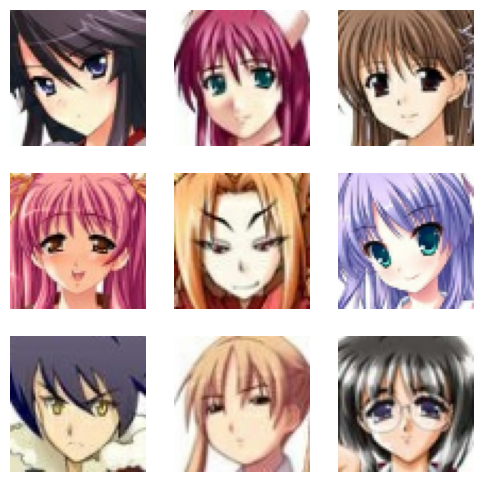

In [ ]:
# Extract a batch of images from the dataset
sample_images = next(iter(data))

# Plot the images
plt.figure(figsize=(6, 6))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i].numpy().astype("uint8"))
    plt.axis("off")

plt.show()

In [ ]:
# Normalizing the input image to the range [-1, 1]
data = data.map(lambda d: (d - 127.5) / 127.5)
data

<_MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

# 4. Build the Generator

In [ ]:
# Build the Generator function
def build_generator(latent_dim):
    generator = Sequential()

    generator.add(Dense(units=4*4*256, input_shape=(latent_dim,), use_bias=False))
    generator.add(Reshape((4, 4, 256)))
    generator.add(BatchNormalization())

    generator.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu"))
    generator.add(BatchNormalization())

    generator.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu"))
    generator.add(BatchNormalization())

    generator.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu"))
    generator.add(BatchNormalization())

    generator.add(Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="tanh"))

    return generator

# Instantiate the generator model
latent_dim = 100
G_model = build_generator(latent_dim)
G_model.summary()
# optimizer
G_optm = Adam(1e-4)

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 4096)              409600    
                                                                 
 reshape_11 (Reshape)        (None, 4, 4, 256)         0         
                                                                 
 batch_normalization_31 (Ba  (None, 4, 4, 256)         1024      
 tchNormalization)                                               
                                                                 
 conv2d_transpose_37 (Conv2  (None, 8, 8, 128)         295040    
 DTranspose)                                                     
                                                                 
 batch_normalization_32 (Ba  (None, 8, 8, 128)         512       
 tchNormalization)                                               
                                                     

# 5. Build the Discriminator

In [ ]:
# Discriminator
def build_discriminator():
    discriminator = Sequential()

    discriminator.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding="same", activation=tf.nn.leaky_relu, input_shape=(64, 64, 3)))
    discriminator.add(BatchNormalization())
    discriminator.add(Dropout(0.2))

    discriminator.add(Conv2D(128, kernel_size=3, strides=(2, 2), padding="same", activation=tf.nn.leaky_relu))
    discriminator.add(BatchNormalization())
    discriminator.add(Dropout(0.2))

    discriminator.add(Conv2D(256, kernel_size=3, strides=(2, 2), padding="same", activation=tf.nn.leaky_relu))
    discriminator.add(BatchNormalization())
    discriminator.add(Dropout(0.2))

    discriminator.add(Flatten())
    discriminator.add(Dropout(0.2))
    discriminator.add(Dense(units=1, activation="sigmoid"))

    return discriminator

# Instantiate the discriminator model
D_model = build_discriminator()
D_model.summary()

# optimizer
D_optm = Adam(1e-4)

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_35 (Ba  (None, 32, 32, 64)        256       
 tchNormalization)                                               
                                                                 
 dropout_20 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_34 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 batch_normalization_36 (Ba  (None, 16, 16, 128)       512       
 tchNormalization)                                               
                                                                 
 dropout_21 (Dropout)        (None, 16, 16, 128)     

# 6. Define the GAN Model

In [ ]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Generate fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine real and fake images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Create labels for the discriminator
        labels_discriminator = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        # Add random noise to the labels (label smoothing)
        labels_discriminator += 0.05 * tf.random.uniform(tf.shape(labels_discriminator))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions_discriminator = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels_discriminator, predictions_discriminator)

        grads_discriminator = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads_discriminator, self.discriminator.trainable_weights))

        # Generate new random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Create labels that say "all real images"
        misleading_labels_generator = tf.zeros((batch_size, 1))

        # Train the generator (do not update discriminator weights)
        with tf.GradientTape() as tape:
            predictions_generator = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels_generator, predictions_generator)

        grads_generator = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads_generator, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [ ]:
# loss function
loss_fn = tf.keras.losses.BinaryCrossentropy()

In [ ]:
# Defining GAN model
model = GAN(discriminator=D_model, generator=G_model, latent_dim=latent_dim)

# 7. Compile & Train the GAN Model

In [ ]:
# Compiling GAN Model
model.compile(d_optimizer=D_optm, g_optimizer=G_optm, loss_fn=loss_fn)

In [ ]:
# number of epochs
epochs = 35
# Fitting the GAN model
history = model.fit(data, epochs=epochs)

Epoch 1/35
1987/1987 [==============================] - 45s 20ms/step - d_loss: -0.2002 - g_loss: 90.6418
Epoch 2/35
1987/1987 [==============================] - 39s 20ms/step - d_loss: 0.2597 - g_loss: 3.2737
Epoch 3/35
1987/1987 [==============================] - 39s 20ms/step - d_loss: 0.2758 - g_loss: 3.0376
Epoch 4/35
1987/1987 [==============================] - 39s 20ms/step - d_loss: 0.2875 - g_loss: 2.8501
Epoch 5/35
1987/1987 [==============================] - 39s 20ms/step - d_loss: 0.3179 - g_loss: 2.6422
Epoch 6/35
1987/1987 [==============================] - 39s 20ms/step - d_loss: 0.3368 - g_loss: 2.4768
Epoch 7/35
1987/1987 [==============================] - 39s 20ms/step - d_loss: 0.3260 - g_loss: 2.4815
Epoch 8/35
1987/1987 [==============================] - 39s 20ms/step - d_loss: 0.2985 - g_loss: 2.5665
Epoch 9/35
1987/1987 [==============================] - 39s 20ms/step - d_loss: 0.2911 - g_loss: 2.7416
Epoch 10/35
1987/1987 [==============================] - 39s 2

# 8. Generate High-Quality Anime Faces


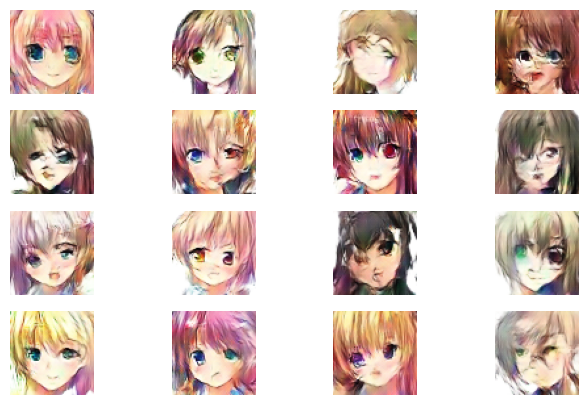

In [ ]:
# Creating random noise to feed it to the trained Generator model
noise = tf.random.normal([32, 100])

# Generating new images using the trained Generator model
generated_images = G_model(noise, training=False)

# Converting the input image to the range [0, 255]
generated_images1 = (generated_images+127.5)*127.5
# Plotting the generated images
plt.figure(figsize=(8, 5))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(generated_images1[i].numpy().astype("uint8"))
    plt.axis('off')

plt.show()


These are generated fake images!

# 9. Generator and Discriminator Losses

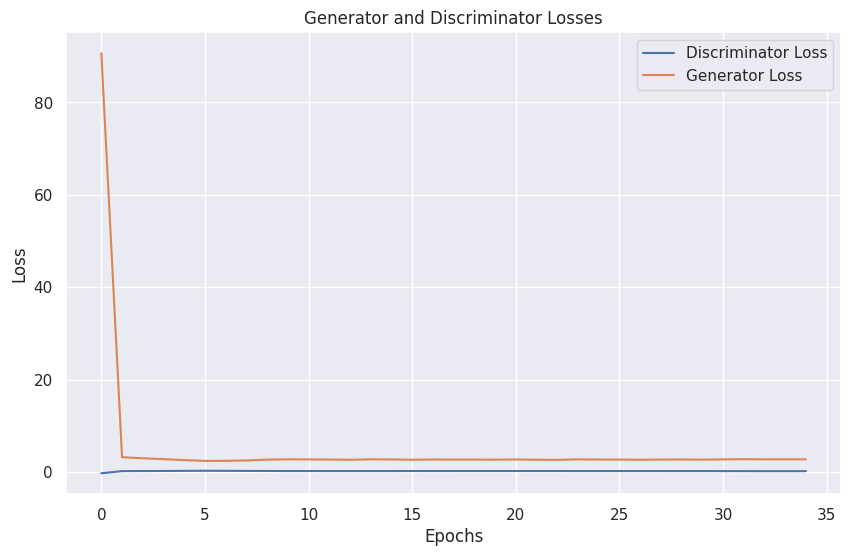

In [ ]:
# Function to create a figure for the losses
def create_loss_figure(d_loss_values, g_loss_values):
    plt.figure(figsize=(10, 6))
    plt.plot(d_loss_values, label='Discriminator Loss')
    plt.plot(g_loss_values, label='Generator Loss')
    plt.title('Generator and Discriminator Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Access the loss values from the history
d_loss_values = history.history['d_loss']
g_loss_values = history.history['g_loss']

# Call the create_loss_figure function with the loss values
create_loss_figure(d_loss_values, g_loss_values)